In [1]:
from lxml import etree
import pandas as pd
import swifter
import numpy as np
import re
import geopandas
import wikitextparser
import mwparserfromhell as mwp
MAX_SEQ_LENGTH = 200

In [2]:
parse = etree.iterparse("data/wiki_coords_utf8.xml", huge_tree=True, tag='page')

In [3]:
dicts = []
for tag, page in parse:
    _dict = {}
    for node in page:
        _dict[node.tag] = node.text

    dicts.append(_dict)


In [4]:
df = pd.DataFrame(dicts)

In [5]:
df = df[df.coords.str.contains("[0-9]", regex=True)]

In [6]:
df.loc[:, ['is_dec']] = ~df.coords.str.contains("\|N\||\|S\||\|W\||\|E\|", regex=True)

In [7]:
def clean_dec(x):
    try:
        lat_str = x[1]
        lon_str = x[2]
        lat = float(lat_str)
        lon = float(lon_str)
        return np.array([lat, lon])
    except:
        return np.array([None, None])

In [8]:
df_dec = df[df.is_dec]
df_dec.loc[:, ["dec"]] = df_dec.coords.swifter.apply(lambda x: re.split('\||}', x)).apply(clean_dec)
df_dec = df_dec[df_dec.dec.swifter.apply(lambda x: len(x)) == 2]

Pandas Apply:   0%|          | 0/319333 [00:00<?, ?it/s]

/Users/hhoferic/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Pandas Apply:   0%|          | 0/319333 [00:00<?, ?it/s]

In [9]:
df_dec.loc[:, ["lat"]] = df_dec.dec.swifter.apply(lambda x: x[0])
df_dec.loc[:, ["lon"]] = df_dec.dec.swifter.apply(lambda x: x[1])

Pandas Apply:   0%|          | 0/319333 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/319333 [00:00<?, ?it/s]

In [10]:
def is_float(el):
    try:
        float(el)
        return True
    except ValueError:
        False

In [11]:
def nodec2dec(toklist):
    _dir = 'lat'
    lat_dir = ''
    lon_dir = ''
    pos = 0
    coord = {}
    for tok in toklist:
#         print(tok)
        tok = tok.strip()
        if tok == 'N' or tok == 'S':
            _dir = 'lon'
            lat_dir = tok
            pos = 0
            continue
        if tok == 'E' or tok == 'W':
            lon_dir = tok
            try:
                lat = coord['lat'] if lat_dir == 'N' else (-1)*coord['lat']
                lon = coord['lon'] if lon_dir == 'E' else (-1)*coord['lon']
                return np.array([lat, lon])
            except:
                return np.array([None, None])

        if tok.isnumeric() or is_float(tok):
            if pos == 0:
                coord[_dir] = abs(float(tok))
                pos+=1
            elif pos == 1:
                coord[_dir] += abs(float(tok))/60
                pos+=1
            elif pos == 2:
                coord[_dir] += abs(float(tok))/3600
                pos+=1

    return np.array([None, None])


In [12]:
df_no_dec = df[~df.is_dec]
df_no_dec.loc[:, ['split']] = df_no_dec.coords.swifter.apply(lambda x: re.split('\||}' ,x))
df_no_dec.loc[:, ['dec']] = df_no_dec.split.swifter.apply(lambda x: nodec2dec(x))
df_no_dec.loc[:,["lat"]] = df_no_dec.dec.swifter.apply(lambda x: x[0])
df_no_dec.loc[:,["lon"]] = df_no_dec.dec.swifter.apply(lambda x: x[1])

Pandas Apply:   0%|          | 0/914819 [00:00<?, ?it/s]

/Users/hhoferic/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Pandas Apply:   0%|          | 0/914819 [00:00<?, ?it/s]

/Users/hhoferic/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Pandas Apply:   0%|          | 0/914819 [00:00<?, ?it/s]

/Users/hhoferic/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Pandas Apply:   0%|          | 0/914819 [00:00<?, ?it/s]

/Users/hhoferic/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [13]:
df_union = pd.concat([df_no_dec, df_dec]).dropna(subset=['text', 'dec'])

In [14]:
df_union = df_union[df_union.dec.apply(lambda x: len(x)) == 2]

In [15]:
df_sane = df_union[(df_union.lat < 90) & (df_union.lat > -90) & (df_union.lon >= -180) & (df_union.lon <= 180)]

In [16]:
df_sane = df_sane[df_sane.lon != 0]

In [17]:
df_sane.shape

(1229694, 8)

In [18]:
def parse_mw(text):
    try:
        # return wikitextparser.parse(text).plain_text()
        return mwp.parse(text).strip_code()
    except AttributeError:
        return ''


In [19]:
parsed_text = df_sane.text.swifter.apply(parse_mw)

Pandas Apply:   0%|          | 0/1229694 [00:00<?, ?it/s]

In [20]:
df_sane["parsed_text"] = parsed_text

In [21]:
special_punct = re.compile("(\[[0-9]*\])|[\]\[!\"#$%&'()*+/:;<=>?@\^_`{|}~-]")
df_sane["parsed_text"] = df_sane.parsed_text.str.replace("\n","").swifter.apply(lambda x: special_punct.sub("", x))

Pandas Apply:   0%|          | 0/1229694 [00:00<?, ?it/s]

In [22]:
df_sane.shape

(1229694, 9)

In [23]:
df_sane = df_sane[~(df_sane.parsed_text == '')]

In [24]:
df_sane.shape

(1229542, 9)

In [25]:
def chunk_text(string):
    split_string = string.replace("\n", " ").lower().split(' ')
    chunked_text = [" ".join(split_string[i:i+MAX_SEQ_LENGTH]) for i in range(0,len(split_string), MAX_SEQ_LENGTH)]
    return chunked_text

In [26]:
df_sane["chunked_text"] = df_sane.parsed_text.swifter.apply(chunk_text)

Pandas Apply:   0%|          | 0/1229542 [00:00<?, ?it/s]

In [27]:
df_sub = df_sane[["chunked_text", "lat", "lon"]].explode("chunked_text")

<AxesSubplot:xlabel='lon', ylabel='lat'>

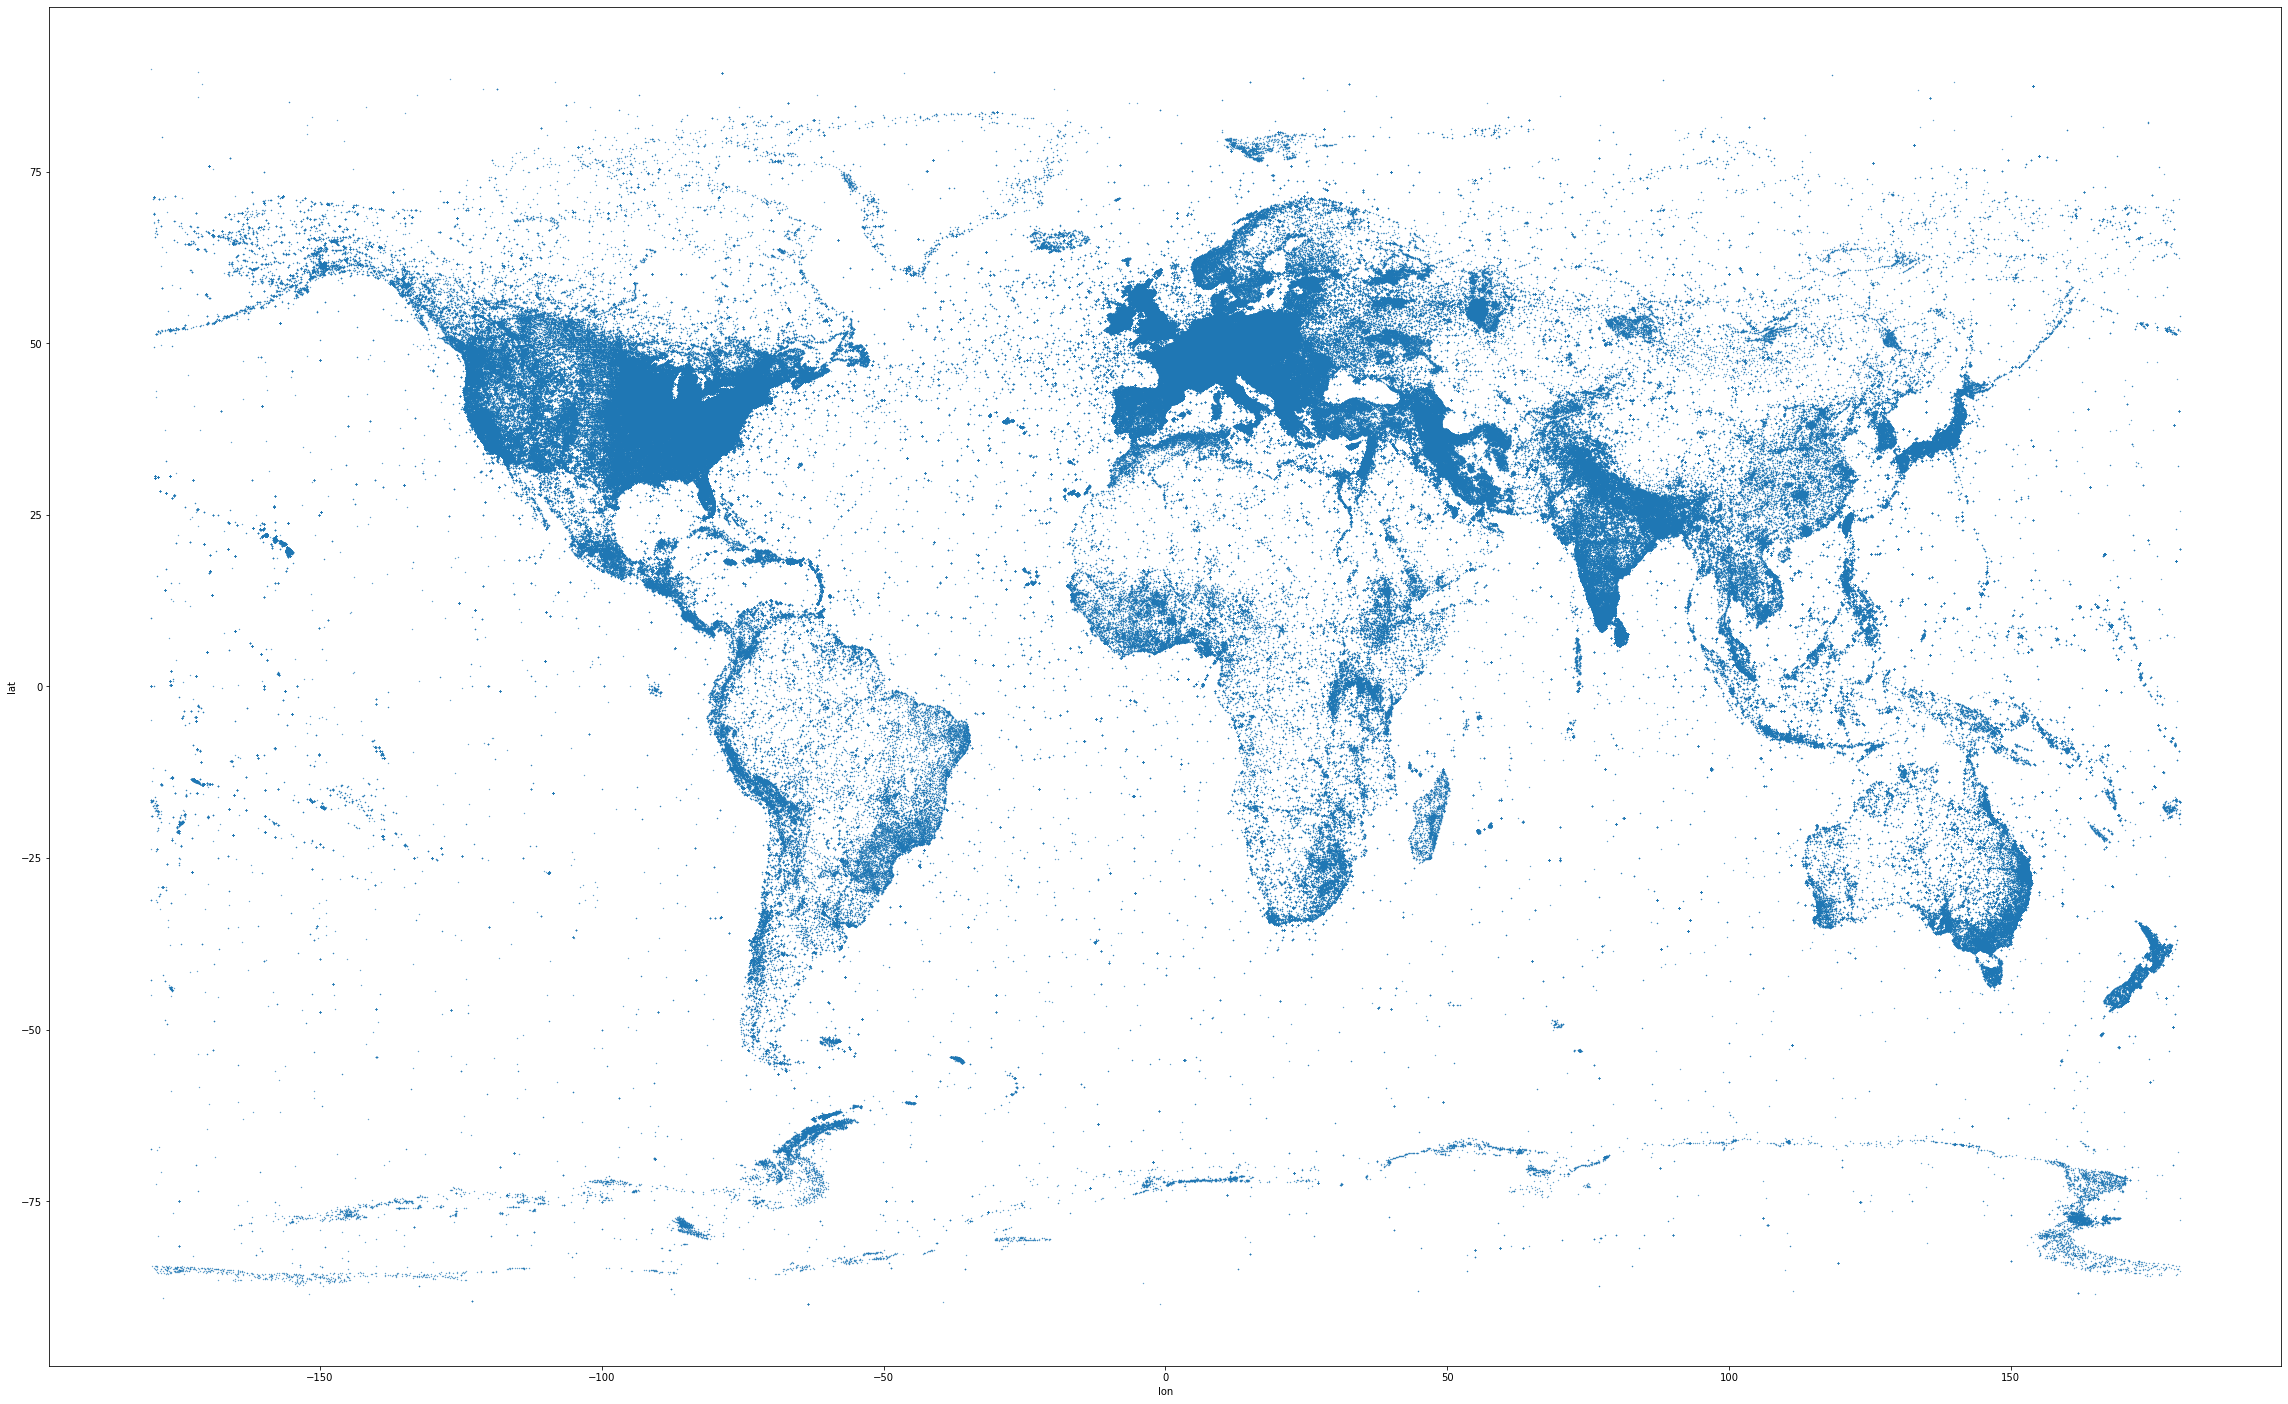

In [32]:
df_sub[['lat', 'lon']].plot.scatter(x='lon', y='lat', figsize=(40,25), s=0.1)

In [36]:
df_final = df_sub.rename(columns={"chunked_text": "text"})[['text', 'lat', 'lon']]

In [37]:
df_final.to_parquet('data/wiki_utf8_exploded.parquet')

In [38]:
df_final.shape[0]/100

32874.22